## Exploration 4. 인공지능으로 세상에 없던 새로운 패션 만들기

# [Ver.2] Project 'CIFAR-10 이미지 생성하기'

**[프로젝트 목표]**
- DCGAN 모델 구조를 이용해서 CIFAR-10 데이터를 생성하는 모델 구현

## ✨ver.2 수정사항✨
**진행과정에서 놓쳤던 일부 코드를 수정하고, 성능개선에 집중**
- [블로그](https://medium.com/@stepanulyanin/dcgan-adventures-with-cifar10-905fb0a24d21) 내용을 참고해서 모델 구조 전체를 수정했다.
- 수정사항에 대해 ✅를 표시

---

# 💡 성능개선 참고 

1. [DCGAN paper “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks”](https://arxiv.org/abs/1511.06434)


2. [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)

- The tips draw upon the suggestions from the DCGAN paper as well as elsewhere.
- A summary of some of the more actionable tips is provided below.

    - **Normalize inputs to the range [-1, 1]** and use **tanh in the generator output**.
        - -1\~1로 정규화하기때문에 같은 범위에 매핑하기위해 tanh 활성화함수를 사용해야한다.
    - **Flip the labels and loss function** when training the generator.
        - label과 loss function을 뒤집는다?
        - 학습중에 반대 라벨을 사용한다는 의미 : 실제 샘플에 1로 label이 지정되면 generator를 훈련하는 동안에 `0`으로 처리한다
        - 이렇게하면 overfitting을 방지할수 있다고 함(chatGPT설명)
    - **Sample Gaussian random numbers** as input to the generator.
        - 통계에서도 이야기했던것 같은데 지금은 잘 이해가 되지 않으니 일단 패스
    - Use **mini batches of all real or all fake for calculating batch norm statistics**.
    - Use **Leaky ReLU in the generator and discriminator**.
    - Use **Average pooling and stride for downsampling**; use **ConvTranspose2D and stride for upsampling**.
    - Use **label smoothing in the discriminator, with small random noise**.
        - smoothing이라는 개념이 통계에서 '평활화'한다는 뜻으로 나왔던것 같은데, 이 역시 일단 패스
    - Add **random noise to the labels in the discriminator**.
    - Use **DCGAN architecture**, unless you have a good reason not to.
    - A loss of 0.0 in the discriminator is a failure mode.
    - If loss of the generator steadily decreases, it is likely fooling the discriminator with garbage images.
    - **Use labels if you have them**
    - Add noise to inputs to the discriminator and decay the noise over time.
    - Use **dropout of 50 percent during train and generation**.

✅ **이 내용들을 포함한 [blog](https://medium.com/@stepanulyanin/dcgan-adventures-with-cifar10-905fb0a24d21) 내용을 참고해서 작업해볼 예정** 


---
# Step1. 작업환경 구성

In [1]:
# # To generate GIFs
# !pip install imageio

In [2]:
# # prepare folders for dataset, training
# !mkdir -p /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/generated_samples
# !mkdir -p /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/training_checkpoints
# !mkdir -p /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/training_history

- 터미널에서 일일이 디렉토리를 만드는게 아니고, os를 이용해서 현재 디렉토리 폴더를 중심으로 새로운 폴더를 만드는 코드를 사용해본다
- library를 불러올때 크게 신경쓰지않고 필요한 것들을 모두 한꺼번에 모아서 불러오는것만 했는데, 이번 프로젝트 코드피어리뷰에서 [선재님 노트북](https://github.com/thetjswo/AIFFEL_Quest/blob/main/Exploration/Ex4/%5BDL-DCGAN%5DCreate_data_that_did_not_exist%2CGenerative_Modeling(project).ipynb)을 보고 자극을 받아 각 라이브러리가 어떤 역할을 하는지 적어보려고한다!

In [1]:
## import library

# for file path access
import os
# for usiing global variables
import glob
# for accessing time data
import time
# for generating gifs
import imageio
# for image visualization
import PIL
# for printing progress of training
from tqdm import tqdm
# for data visualization
from IPython import display

import matplotlib.pyplot as plt
%matplotlib inline

# for math operations
import numpy as np
# for managing tensors
import tensorflow as tf
# for model design
from tensorflow.keras import layers

# version check
print('tensorflow', tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


In [2]:
# prepare directories for dataset, training

# get the current working directory
current_directory = os.getcwd()

# specify the new directory path
new_directory_path = 'dcgan_newimage/cifar10/ver2'

# create the full path for the new directories
new_directory_full_path = os.path.join(current_directory, new_directory_path)

# specify the new directory name
new_directories = ['generated_samples', 'training_checkpoints', 'training_history']

# create new directories within the full path
for directory_path in new_directories:
    # concatenate full path and new directory path
    combined_path = os.path.join(new_directory_full_path, directory_path)
    
    # check if the directory already exists
    if not os.path.exists(combined_path):
        # create the new directory
        os.makedirs(combined_path)
        print(f"New directory '{directory_path}' created at {combined_path}")
    else:
        print(f"Directory '{directory_path}' already exists at {combined_path}")

Directory 'generated_samples' already exists at /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/generated_samples
Directory 'training_checkpoints' already exists at /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/training_checkpoints
Directory 'training_history' already exists at /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/training_history


---
# Step2. 데이터셋 구성

## Load data

- CIFAR-10 데이터셋 활용
- 분류문제에서 사용했던 label이 필요 없음 -> `_(underscore)`로 해당 데이터(`y_train`, `y_test`)는 사용x

In [3]:
# use cifar10 dataset
cifar10 = tf.keras.datasets.cifar10

(x_train, _), (x_test, _) = cifar10.load_data() # label data도 사용

x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

- 참고한 블로그를 보면 검증데이터가 필요한게 아니라 train, test 데이터를 하나로 합쳤다
- 나도 이부분을 적용해서 따라가본다

In [4]:
# fuse the train set and test set
x_train = np.concatenate((x_train, x_test), axis = 0)
x_train.shape

(60000, 32, 32, 3)

In [5]:
print('max pixel:', x_train.max())
print('min pixel:', x_train.min())

max pixel: 255
min pixel: 0


- 첫번째 노트북에서는 처음부터 -1\~1 범위로 픽셀정규화를 했는데, tanh함수를 이용해서 이미지를 생성할때 해당 범위로 변환되도록 지금은 0~1 범위로 정규화한다

In [8]:
# # pixel normalization
# x_train = (x_train - 127.5) / 127.5  # Normalize the images to [-1, 1]

# print('max pixel:', x_train.max())
# print('min pixel:', x_train.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
# pixel normalization
x_train = x_train / 255  # Normalize the images to [0, 1]

print('max pixel:', x_train.max())
print('min pixel:', x_train.min())

max pixel: 1.0
min pixel: 0.0


In [7]:
# check shape, data type
x_train.shape, x_train.dtype

((60000, 32, 32, 3), dtype('float64'))

- float64는 메모리를 더 많이 차지하고, 32bit floating point number보다 연산속도가 느림
    - float32로 수정해서 사용

In [8]:
# data type 변경 
x_train = x_train.astype('float32')
x_train.shape, x_train.dtype

((60000, 32, 32, 3), dtype('float32'))

- train dataset : 60,000
- 이미지 사이즈 : 32x32
- 컬러이미지

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


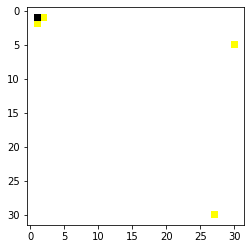

In [11]:
# # visualize image
# plt.imshow((x_train[0]*127.5) + 127.5) # Rescale values to original
# plt.show() 

- 정규화했던 픽셀값을 다시 원래대로 돌려야 출력될거라고 생각했는데, 아니었다.
- `plt.imshow()` [공식문서](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) 설명을 보면
> **X : array-like or PIL image**<br>(M, N, 3): an image with RGB values (0-1 float or 0-255 int)

이렇게 되어있는데, 이미지 데이터 **type을 float형**으로 변환했기 떄문에 **0-255 int**에 맞추는게 아니라 **0-1 float**에 맞춰야한다!! 
- 지금 -1\~1 사이의 값이니까 `+1`을 해서 `0~2`로 만들고 `/2`를 해서 최종 `0~1`로 맞춘다

---

0-1 사이값으로 정규화했기때문에 지금은 따로 숫자 조정 필요X

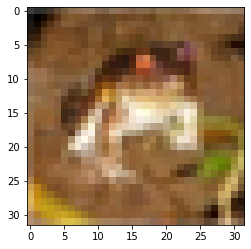

In [9]:
# visualize image 1
plt.imshow(x_train[0]) 
plt.show() 

- 이미지 사이즈가 32밖에 안되서인지 화질이 정말 좋지 않다

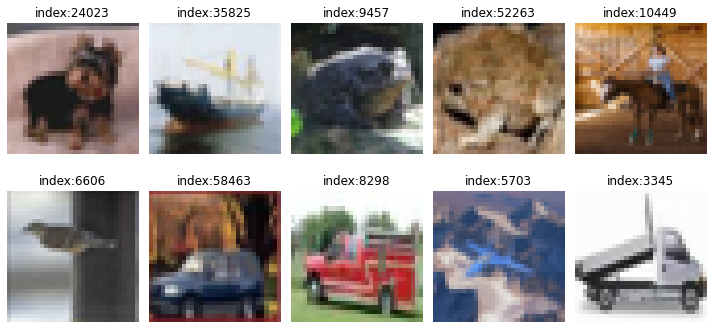

In [10]:
# visualize random 10 images
import random

plt.figure(figsize=(10,5))

# generate 10 random indices
random_indices = random.sample(range(len(x_train)), 10)

for i, index in enumerate(random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow((x_train[index]))
    plt.title(f'index:{index}')
    plt.axis('off') # Optional: Turn off axis labels for better visualization
    
plt.tight_layout()
plt.show()

## tf.Dataset 미니배치 사용
- 데이터가 잘 섞이게 하려면 BUFFER_SIZE를 총 데이터사이즈와 같게 하거나 크게 설정!
- 배치사이즈는 블로그를 참고해서 128으로 설정
    - [논문](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)에서 사용했던 코드를 보니 기본값을 100으로 설정하고 매번 따로 입력받는 형식으로 한것 같다


- ✅ 블로그에서는 배치사이즈는 128로 설정하고, 모델훈련하는 과정에서 배치사이즈에 맞춰서 훈련하는 코드를 사용했지만, 노드대로 따로 미니배치 dataset을 만든다

In [11]:
# use tf.Dataset
BUFFER_SIZE = 60000  # to shuffle whole dataset
BATCH_SIZE = 128

In [12]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

---

# Model - DCGAN

- Deep Convolutional Generative Adversarial Network

---

## 💡 [GAN Generative Adversarial Network](https://arxiv.org/pdf/1406.2661.pdf)
- 생성 모델
- network : 
    - **Generator 생성자** : random noise에서 이미지 형상의 벡터를 생성
    - **Discriminator 판별자** : 기존의 진짜 이미지와 생성자가 만든 이미지를 입력받아 실제여부를 판단-실수값으로 출력
- 2개의 네트워크가 서로 경쟁하며 파라미터를 조정해서 더 구별하기 어려운 이미지가 생성되는 방식
    
**[REF]** [OpenAI-Generative models](https://openai.com/research/generative-models)

---

# Creat the models
**[REF]** [tf tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

💡 [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)
> CIFAR-10 is a small, well studied dataset of 32 × 32 natural images.<br> We use this data set to study semi-supervised learning, as well as to examine the visual quality of samples that can be achieved.<br>
For the **discriminator** in our GAN we **use a 9 layer deep convolutional network with dropout and weight normalization**. <br>**The generator is a 4 layer deep CNN with batch normalization**

---

# Step 3. Generator 모델 구현

## The Generator
The generator uses [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (upsampling) layers to produce an image from a seed (random noise). 

- Start with a Dense layer that takes this seed as input
- then upsample several times until you reach the **desired image size of 32x32x3**
- Notice the **[`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer**, except **the output layer which uses tanh**.


- `Conv2DTranspose`는 일반적인 `Conv2D`와 반대로 이미지 사이즈를 넓혀줌 ([transposed convolution](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11))
- `Conv2DTranspose` 3번 진행 : 위 논문을 참고해서 `(4, 4, 512) → (8, 8, 256) → (16, 16, 128) → (32, 32, 3)` 순으로 준비한 데이터셋과 동일한 사이즈까지 이미지를 키워감
    - ✅ 이 숫자를 어떻게 설정해야할지 아직 정확한 이해는 되지않지만, 선재님과 코드리뷰할때 나눈 내용은 32x32x3을 맞추기 위해 2로 나눈 숫자 값이 아닐까 결론내렸다
    - ✅ 블로그를 참고해서 **deconv layer를 4개**로 사용할예정이라 `(2, 2, 256) → (4, 4, 128) → (8, 8, 64) → (16, 16, 32) → (32, 32, 3)` 으로 변경
    - ✅ [논문 코드](https://github.com/openai/improved-gan/blob/master/mnist_svhn_cifar10/train_cifar_feature_matching.py)를 보면 가중치초기화 0.5를 지정하고, 블로그는 xavier initializer를 사용한다.
        > 가중치 행렬(W)은 표준 편차가 0.05(W=Normal(0.05))인 정규 분포를 사용하여 초기화<br>
        > [tf.keras.initializers.RandomNormal](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomNormal)


- ✅ 이번 모델 구조는 블로그 구조를 참고한다         
    - 노드와는 다르게 모델 구조에서 noise를 생성을 염두하고 이 부분에 대한 코드라인을 넣어두었다
    - **xavier initializer 사용**
        - blog code는 텐서플로우 이전버전이라 `tf.contrib.layers.xavier_initializer()`를 사용했는데 버전업데이트에 따라 코드를 수정함
        > `tf.contrib.layers.xavier_initializer()` should be replaced by **`tf.keras.initializers.GlorotUniform()`**<br>
`tf.contrib.layers.xavier_initializer(uniform=False)` should be replaced by `tf.keras.initializers.GlorotNormal()` [REF](https://stackoverflow.com/questions/64255154/change-tf-contrib-layers-xavier-initializer-to-2-0-0)
    - **kernel size=5 (receptive field)**
    - **strides=2**
    - **padding=same**
    - **leaky ReLU alpha=0.2**
    - **strat with 100 to 1024 dense map and transform 1024 nodes into a volume of 2x2x256**
    - **batch normalization on every layer**
    - **apply leaky ReLU to every layer but the last one**
    - **apply hypertangent activation function to obtain the image of 3ch with pixel values between -1 and 1**
        - 앞에서 픽셀정규화를 -1, 1범위를 지정해서 나온다고 생각했는데, 255로 나눠서 0-1 범위로 만든후에 tanh함수를 사용해도 -1~1 범위를 얻을수 있다
         

In [13]:
def make_generator_model():   
    model = tf.keras.Sequential()
    
    # reshape the noise into a volume : 2x2x256
    model.add(layers.Dense(2*2*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Reshape((2, 2, 256)))
    assert model.output_shape == (None, 2, 2, 256)  # Note: None is the batch size

    # Deconv - upsample : 4x4x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False,
                                     kernel_initializer='glorot_uniform'))
    assert model.output_shape == (None, 4, 4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    
    # Deconv - upsample : 8x8x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False,
                                     kernel_initializer='glorot_uniform'))
    assert model.output_shape == (None, 8, 8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))


    # Deconv - upsample : 16x16x32
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False,
                                     kernel_initializer='glorot_uniform'))
    assert model.output_shape == (None, 16, 16, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Deconv - upsample : 32x32x3 & output img
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False,
                                     kernel_initializer='glorot_uniform', 
                                     activation='tanh')) 
    assert model.output_shape == (None, 32, 32, 3)
    
    return model

In [14]:
# check generator
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              102400    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 128)         0

## Generator로 random noise 생성
- tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다

In [15]:
# random noise vector
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False) # 지금은 trianing이 아니기때문에 'training=False'로 지정
generated_image.shape 

TensorShape([1, 32, 32, 3])

batch_size=1인 (32, 32, 3)shape의 이미지가 생성됨

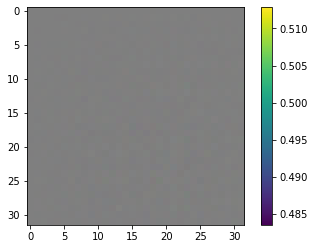

In [17]:
# Visualize random noise
plt.imshow((generated_image[0] + 1) / 2) # rescale to 0-1
plt.colorbar()
plt.show()

# Step 5. Discriminator 모델 구현

## The Discriminator
- CNN-based image classifier
> For the discriminator in our GAN we use a **9 layer deep convolutional network with dropout and weight normalization**

- [논문](https://proceedings.neurips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)에서는 discriminator에서 **Weight normalization 가중치정규화**도 진행했다고 하는데, 일단 model 구조만 참고해서 구현하고, 성능개선할 시간이 생기면 그때 이 부분에 대해 찾아보고 시도해보려고한다
    > **Weight normalization** is a technique introduced in the paper "Weight Normalization: A Simple Reparameterization to Accelerate Training of Deep Neural Networks" by Tim Salimans and Diederik P. Kingma. <br>The idea behind **weight normalization is to decouple the length of weight vectors from their direction, allowing the optimization process to converge faster**.
    - ✅ 이걸 적용하려면 `Lasagne library`를 사용해야하고 모델 구조를 전체적으로 바꿔야할것같다. 일단 블로그를 참고해서 모델을 만들어보고, 추가 개선때 한번 시도해본다
- ✅ discriminator 구조는 블로그를 참고
    > Discriminator is a basic CNN<br>
    > No batch normalization on the first layer of the discriminator<br>
    > There are no max or any other pooling layers for down-sampling<br>
    > Xavier initializer is used for the kernel<br>
    > Perceptive field(kernel size) is of size 5<br>
    > Stride is of size 2<br>
    > Padding is ‘same’<br>
    > Leaky ReLU is used as an activation function on every layer, but not the last one<br>
    > **Standard sigmoid activation** is used on the output of the network to determine the probability that the image is generated
    
- 마지막 logit layer에서 이진분류작업(가짜, 실제)의 경우에는 sigmoid를 쓰면 확률로 변환하는게 더 편해서 사용한다고 한다

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
      
    # Conv layer 1 - 32x32x3 -> 16x16x364
    ### don't use batch norm on the first layer
    model.add(layers.Conv2D(32, (5, 5), strides=2, padding='same', 
                            kernel_initializer='glorot_uniform',
                            input_shape=(32, 32, 3))) 
    model.add(layers.LeakyReLU(alpha=0.2))

    # Conv layer 2 - 16x16x64 -> 8x8x128
    model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same',
                            kernel_initializer='glorot_uniform'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
   
    # Conv layer 3 - 8x8x128 -> 4x4x256
    model.add(layers.Conv2D(128, (5, 5), strides=2, padding='same',
                            kernel_initializer='glorot_uniform'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Conv layer 4 - 4x4x256 -> 2x2x512
    model.add(layers.Conv2D(256, (5, 5), strides=2, padding='same',
                            kernel_initializer='glorot_uniform'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Flatten the array
    ### Using global average pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D()) 

    # Logits
    ### node 1 : goal is to have a binary output => whether the input is real or fake
    model.add(layers.Dense(1, activation=None,
                           kernel_initializer='glorot_uniform'))
    
    # Output
    ### Using sigmoid activation funciton
    model.add(layers.Activation('sigmoid'))
              
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. 
- The model will be trained to output positive values for real images, and negative values for fake images.

In [19]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49998277]], shape=(1, 1), dtype=float32)


- decision 값이 0에 가까우면 fake **=> 결과값 : 아직은 fake**
- decision 값이 1에 가까우면 real 로 간주


# Step 5. 손실함수, 최적화 구현 : Define the loss, optimizer

## Loss function - cross entropy
- GAN은 loss funciton으로 교차 엔트로피를 사용(Cross Entropy)
    - 두 확률 분포의 차이를 구할때 사용
- Discriminator는 한 개의 이미지를 가짜(0)인지 진짜(1)인지 판별 -> 이진분류 : binary cross entropy 사용

- `BinaryCrossEntropy` : input은 0 - 1 사이의 확률값이라고 가정 -> `from_logits=True`로 설정해야함
> When from_logits=True, the model's output is considered a logit.<br> **A logit is a raw, unnormalized prediction score** that can range from negative infinity to positive infinity.<br> It **hasn't undergone the final activation function** (e.g., softmax) that would convert it into a probability.<br>
The logit values are useful during the training phase, especially when using loss functions that work directly with logits. This allows for more numerical stability during optimization.


In [20]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

---

💡 아래 model train 코드를 실행하면 <img src='./img/train_error.png'>가 보였다가 사라진다. 
- discriminator에서 sigmoid 함수를 사용해서 이미 0-1 사이의 범위값으로 만들었기때문에 `from_logits=True`를 설정할 필요가 없다.
- 이와 관련한 에러

**[이미지 label]**
- real img : label 1
- fake img : label 0


**cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output**
- fake_output : generator(생성자)가 생성한 Fake Image를 discriminator(구분자)에 입력시켜서 판별된 값 = D(fake_image) 
- real_output : 기존에 있던 Real Image를 discriminator(구분자)에 입력시켜서 판별된 값 = D(real_image) 


**loss 계산을 위해 `tf.zeros_like()`, `tf.ones_like()`사용**
- output shape과 동일한 0 / 1로 채워진 tensor를 만들어서 cross-entropy 비교할때 사용

## generator_loss
generator_loss는 **fake_output이 1**에 가까워지는게 목표 => 잘되면 loss 값은 0에 가까워짐
- tf.ones_like와의 교차 엔트로피값을 계산  
- `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 
    - fake_output이 1(Real Image를 의미)에 가까울수록 **작은 값**을 가짐

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## discriminator_loss
discriminator_loss는 **real_output은 1**에 가까워지기를, **fake_output은 0**에 가까워지는게 목표

- 최종 discriminator_loss 값은 이 둘을 더한 값 => 이 loss 값을 최소화해야함! => 0으로 되면 안되고, loss 값은 0.5에 가까워야함?

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

## discriminator accuracy
discriminator가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산하는것도 GAN의 학습에서 매우 중요!
- 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용


- discriminator가 **real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별**해낸다면?
    - generator가 만들어내는 **fake output이 real output과 차이가 많이 나기 때문**에 판별자가 매우 쉽게 판별해 내고 있다는 뜻
    
    
- real accuracy와 fake accuracy는 **초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적**
    - fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 의미

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 정리하면,

ex. real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

1. tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
> \>> tf.Tensor([False, False, True, True])


2. tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
> \>> tf.Tensor([0.0, 0.0, 1.0, 1.0])


3. tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
> \>> 0.5


## Optimizer Adam
첫번째 학습에서는 `learning rate=0.0001`로 설정
- 이후에 값 조정
- ✅ 0.0005로 수정
- ✅ 블로그에서는 beta값도 설정해준다. 일단 사용해본다

> tf.keras.optimizers.Adam(<br>
>   learning_rate=0.001,<br>
>   beta_1=0.9,<br>
>   beta_2=0.999 ...<br>

> The hyper-parameters 𝛽1 and 𝛽2 of Adam are initial decay rates used when estimating the first and second moments of the gradient, which are multiplied by themselves (exponentially) at the end of each training step (batch). Based on my read of Algorithm 1 in the paper, decreasing 𝛽1 and 𝛽2 of Adam will make the learning slower, so if training is going too fast, that could help. [REF](https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear)
    
**중요한 점! generator, discriminator 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다!**

In [24]:
# set each optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

## random seed
매번 학습이 어떻게 진행되어가고 있는지, 생성자가 생성한 샘플을 확인

- 샘플은 한 번에 16장을 생성
- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있음 => 고정된 seed로 노이즈 생성
- 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터 준비

In [25]:
# make noise sample with random seed
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

---

# Step 6. 훈련과정 상세 기능 구현

# Define the training loop
하나의 미니 배치당 진행할 `train_step` 함수 준비
- `@tf.function` 데코레이터 사용
> **tf.function** : Compiles a function into a callable **TensorFlow graph**


---

💡
**[Tensorflow graph](https://www.tensorflow.org/api_docs/python/tf/Graph)**  
: Graph defines **the flow of data through the operations in a TensorFlow model**
- A TensorFlow computation, represented as a dataflow graph.

Graphs are data structures that contain 
- a set of tf.Operation objects, which represent units of computation
- tf.Tensor objects, which represent the units of data that flow between operations. 

=> In short, **graphs** are extremely useful and let your TensorFlow **run fast**, **run in parallel**, and **run efficiently on multiple devices**

*🤓 무슨 말인지 잘 이해가 안가지만,*
*tf.function을 사용하면 tensorflow가 빠르고, 병렬로, 다중처리를 할수 있도록 해준다고한다*

---

[REF] [blog - python decorator](https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/), [tensorflow tutorial](https://www.tensorflow.org/api_docs/python/tf/function), [tf doc - graph & tf.funcion](https://www.tensorflow.org/guide/intro_to_graphs)

---

## `train_step` function

**train_step 함수 구성**

- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

---

💡 `tf.GradientTape`
- a crucial component in TensorFlow for **automatic differentiation**, a technique used in training machine learning models


1. Context Management:
You use `with tf.GradientTape() as tape`: to define a context where operations are recorded for automatic differentiation.
2. Record Operations:
Inside the `with` block, **any operations involving TensorFlow variables are recorded by the tape**
3. Calculate Gradients:
After executing the operations, you can calculate gradients of a target tensor with respect to some source tensors
4. Automatic Differentiation:
TensorFlow **uses the recorded operations to automatically compute gradients using the backpropagation algorithm**

*🤓 역시 무슨말인지 모르겠지만 tf.GradientTape는 자동미분을 할수 있게 해준다고한다*

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

## 학습현황 시각화 함수 - `generate_and_save_images`
train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수
- 아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다
    - 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화
    - plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    fig = plt.figure(figsize=(8, 8)) # 사이즈를 조금 키움
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

## accuracy, history 시각화 함수 - `draw_train_history`
loss와 accuracy 그래프 시각화는 학습 과정을 체크하기 위해 매우 중요!
- train_step() 함수가 리턴하는 `gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy` 이상 4가지 값을 **history라는 dict 구조에 리스트로 저장**해두고 
- **매 epoch마다 시각화**
    - 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

## checkpoint - `training_checkpoint`
`tf.train.Checkpoint`로 버전관리
- epoch마다 모델 저장
- checkpoint : optimizer와 generator, discriminator(정확히는 생성자와 판별자가 학습한 모델 가중치) 저장

In [29]:
checkpoint_dir = os.getenv('HOME')+'aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Step 7. 학습 과정 진행

# Train the model 

**`train` 함수** : 필요한 함수들 모두 결합
- train_step() : 한 단계 학습
- generate_and_save_images() : 샘플 이미지를 생성하고 저장
- draw_train_history() : 학습 과정을 시각화
- checkpoint : 학습 과정을 시각화

=> 학습과정의 loss, accuracy 그래프 이미지 파일이 training_history 경로에 생성됨 : 진행 과정을 수시확인해보자

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
# set epoch
save_every = 5
EPOCHS = 100 

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

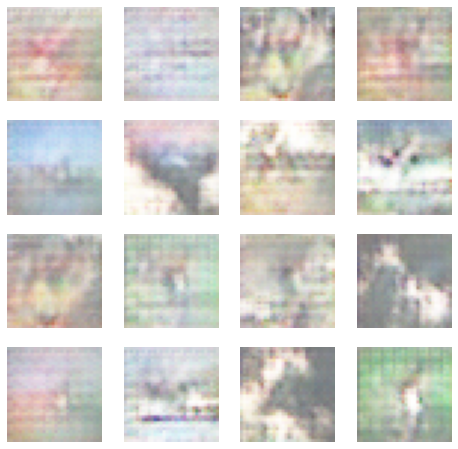

Time for training : 2453 sec


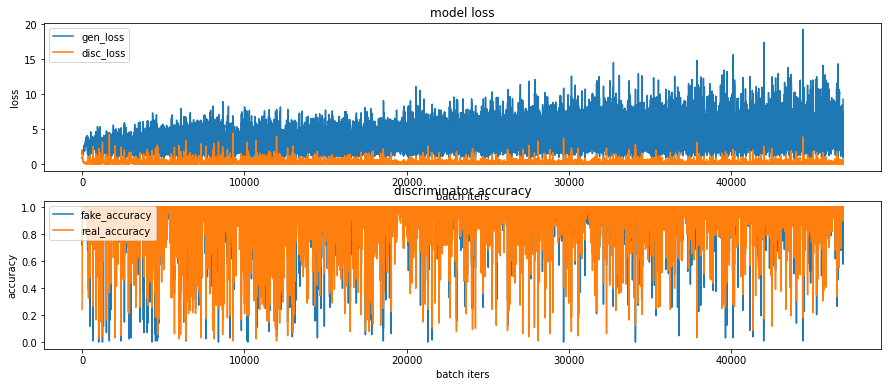

CPU times: user 33min 7s, sys: 3min 55s, total: 37min 3s
Wall time: 40min 56s


In [32]:
%%time

# train
train(train_dataset, EPOCHS, save_every)

- 만약 생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 
    - 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 의미

- 결과물이 아직 흐릿하면 더 많은 epoch으로 학습을 시키거나 모델구조/학습방법 변경



# 학습과정 시각화
학습이 끝난 후 생성했던 샘플 이미지들을 합쳐 GIF 파일(일명 움짤) 생성

- imageio 라이브러리를 활용
    - imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식

In [33]:
anim_file = os.getenv('HOME')+'/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/cifar10_dcgan.gif

-rw-r--r-- 1 root root 7300417 Jan 28 08:54 /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/ver2/cifar10_dcgan.gif


### 지금까지 만들어진 이미지 gif
<img src='./img/ver2_history/cifar10_dcgan.gif'>


### history 저장된 이미지 비교
1.EPOCH 1 <img src='./img/ver2_history/train_history_0000.png'>
2.EPOCH 10 <img src='./img/ver2_history/train_history_0009.png'>
3.EPOCH 20 <img src='./img/ver2_history/train_history_0019.png'>
4.EPOCH 30 <img src='./img/ver2_history/train_history_0029.png'>
5.EPOCH 40 <img src='./img/ver2_history/train_history_0039.png'>
6.EPOCH 50 <img src='./img/ver2_history/train_history_0049.png'>
7.EPOCH 60 <img src='./img/ver2_history/train_history_0059.png'>
8.EPOCH 70 <img src='./img/ver2_history/train_history_0069.png'>
9.EPOCH 80 <img src='./img/ver2_history/train_history_0079.png'>
10.EPOCH 90 <img src='./img/ver2_history/train_history_0089.png'>
11.EPOCH 100 <img src='./img/ver2_history/train_history_0099.png'>
=> 에포크 20 이후부터는 거의 비슷한 양상의 그래프가 기록되었다.

---

# Summary

- 지난 첫번째 노트북의 결과와 큰 차이가 없는것같다.
- 어떤 이미지가 만들어지고 있는 느낌은 들지만 눈으로 구분할수 있을정도의 물체를 만들지는 못하고 있다.
- 그래프의 양상을 보더라도 값이 튀는 범위가 넓긴해도 
    - loss값은 거의 discriminator:1, generator:10 사이에서 머물고 있고
    - accuracy는 둘다 1즈음에 머문다.
- 결과가 잘 생성된 블로그의 generator, discriminator 코드는 최대한 따라해서 만들었지만, 모델훈련하는 부분의 코드가 달라서인지 결과물은 전혀 개선되지 않았다.
- 논문에서의 구조도 하이퍼파라미터를 사용했지만, 정확하게 모델이 동일하지 않아서인지 효과가 없는듯하다.
- 논문의 코드를 그대로 가져와보거나 좋은 결과가 나오는 코드 전체를 똑같이 필사해서 테스트를 해봐야겠다.

---

# KPT

**[KEEP]**
- 다른 사람의 코드를 참고로 다시 GAN의 모델 구조를 천천히 공부해보았다.

**[PROBLEM]**
- GAN이 원래 예민한 모델이라고는 하는데, 그래서 정확하게 어떤 작업을 해야 개선을 할수 있는지 아직 파악이 되지 않는다. 
- 경우의 수가 많은데 기준으로 잡고 수정해나갈 골격 코드가 없다보니 비교하기가 어렵다.


**[TRY]**
- 캐글에 GAN 관련 좋은 결과를 낸 완성된 코드를 똑같이 따라서 해보고 결과물을 비교해본뒤 컴퓨터 사양의 문제도 있는건지 확인해본다